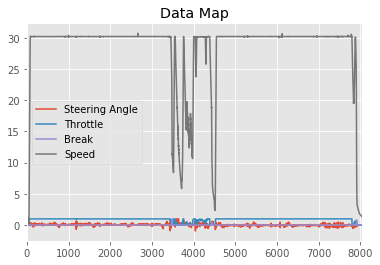

In [1]:
# Visulize all the data set imformation
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DataMap = pd.read_csv('./data/driving_log.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'])

plt.style.use(['ggplot'])
plt.figure(figsize=(10,5))
DataMap.plot(title='Data Map')

In [2]:
print(plt.style.available)

['seaborn-colorblind', 'seaborn-white', 'seaborn-dark-palette', 'seaborn-notebook', 'classic', 'seaborn-whitegrid', 'ggplot', 'seaborn-dark', '_classic_test', 'seaborn-poster', 'seaborn-darkgrid', 'seaborn-bright', 'seaborn-muted', 'seaborn-deep', 'grayscale', 'fivethirtyeight', 'seaborn-paper', 'seaborn', 'seaborn-pastel', 'seaborn-talk', 'seaborn-ticks', 'dark_background', 'bmh']


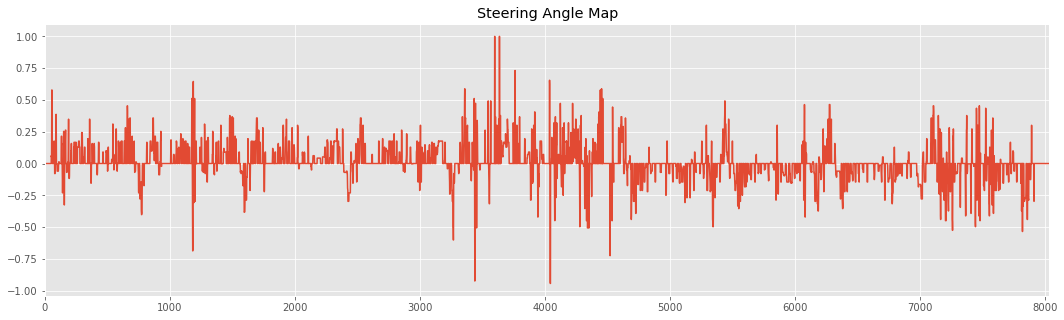

In [3]:
# plot distribution of the main and the only label—steering angle, which is not clearly shown above. 
plt.figure(figsize=(18,5))
DataMap['Steering Angle'].plot(title='Steering Angle Map')

In [4]:
import csv
import cv2
import numpy as np
import sklearn

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense,Dropout
from keras.layers import Lambda,Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

lines =[]
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
images, measurements = [], []
for line in lines:
    for i in range(3):
        source_path=line[i]
        filename=source_path.split('/')[-1]
        #print(filename)
        current_path='./data/IMG/'+filename
        img = cv2.imread(current_path)
        #img1 = cv2.resize(img,(200,66), interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(image)
    measurement = np.float64(line[3])
    correction=0.2
    measurements.append(measurement)
    measurements.append(measurement+correction)
    measurements.append(measurement-correction)

augmented_images, augmented_measurements = [], []
for image,measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)


In [18]:
n_img = len(augmented_images)
img_shape = augmented_images[0].shape
n_label = len(measurements)
print(n_img)
print(img_shape)
print(n_label)

48216
(160, 320, 3)
24108


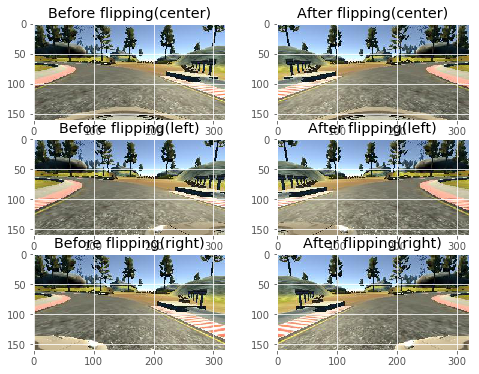

In [19]:
### plot the flipped images
import random

##index = random.randint(0,len(augmented_images))
index = 30
plt.figure(figsize=(8,6))

for i in range(6):
    
    #img = images[index+i].squeeze()
    img = augmented_images[index+i].squeeze()
    plt.subplot(3,2,i+1)
    plt.imshow(img)
    #plt.axis('off')
    # center group
    if i==0:       
        plt.title('Before flipping(center)')
    elif i==1:
        plt.title('After flipping(center)')

    # left group
    elif i==2:
        plt.title('Before flipping(left)')
    elif i==3:
        plt.title('After flipping(left)')

    #right group
    elif i==4:
        plt.title('Before flipping(right)')
    else:
        plt.title('After flipping(right)')

In [20]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples, angles_train, angles_validation = train_test_split(augmented_images, augmented_measurements,
                                                                                test_size=0.2, random_state=42)

In [21]:
print(len(train_samples))
print(len(validation_samples))
print(len(angles_train))
print(len(angles_validation))

38572
9644
38572
9644


In [54]:
'''
#version 1 of generator
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images, measurements = [], []
            for batch_sample in batch_samples:
                for i in range(3):
                    source_path=batch_sample[i]
                    filename=source_path.split('/')[-1]
                    #print(filename)
                    current_path='./data/IMG/'+filename
                    img = cv2.imread(current_path)
                    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(image)
                measurement = np.float64(batch_sample[3])
                correction=0.2
                measurements.append(measurement)
                measurements.append(measurement+correction)
                measurements.append(measurement-correction)
    ###using flip() to augment datas\\            
            augmented_images, augmented_measurements = [], []
            for image,measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)

            X_train=np.array(augmented_images)
            y_train=np.array(augmented_measurements)

            yield sklearn.utils.shuffle(X_train, y_train)
'''

"\ndef generator(samples, batch_size=32):\n    num_samples = len(samples)\n    while 1: # Loop forever so the generator never terminates\n        sklearn.utils.shuffle(samples)\n        for offset in range(0, num_samples, batch_size):\n            batch_samples = samples[offset:offset+batch_size]\n            images, measurements = [], []\n            for batch_sample in batch_samples:\n                for i in range(3):\n                    source_path=batch_sample[i]\n                    filename=source_path.split('/')[-1]\n                    #print(filename)\n                    current_path='./data/IMG/'+filename\n                    img = cv2.imread(current_path)\n                    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n                    images.append(image)\n                measurement = np.float64(batch_sample[3])\n                correction=0.2\n                measurements.append(measurement)\n                measurements.append(measurement+correction)\n           

In [22]:
# version 2 of generator
def generator(samples, a,batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            if a==0:
                batch_angles = angles_train[offset:offset+batch_size]
            elif a==1:
                batch_angles = angles_validation[offset:offset+batch_size]
            else:
                print("Error input.")  
            X_train=np.array(batch_samples)
            y_train=np.array(batch_angles)
            
               
            yield sklearn.utils.shuffle(X_train, y_train)

In [23]:
# compile and train the model using the generator function
train_generator = generator(train_samples, 0, batch_size=32)
validation_generator = generator(validation_samples, 1,batch_size=32)

In [24]:
### Model Sequential
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
# model.add(Lambda(lambda x: x/127.5 - 1.,
#         input_shape=(ch, row, col),
#         output_shape=(ch, row, col)))
model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),border_mode='same',activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),border_mode='same',activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),border_mode='same',activation="relu"))
model.add(Convolution2D(64,3,3,border_mode='same',activation="relu"))
model.add(Convolution2D(64,3,3,border_mode='same',activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.1))
model.add(Dense(50))
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Dropout(0.3))
model.add(Dense(1))

#model.summary()

'''
###LeNet-5
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0)-0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))
'''

'\nmodel.add(Cropping2D(cropping=((70,25),(0,0))))\nmodel.add(Convolution2D(34,5,5,subsample=(2,2),activation="relu"))\nprint(\'Convolute\')\nmodel.add(MaxPooling2D())\nmodel.add(Convolution2D(28,5,5,subsample=(2,2),activation="relu"))\nmodel.add(MaxPooling2D())\nmodel.add(Flatten())\nmodel.add(Dense(60))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(30))\nmodel.add(Dropout(0.3))\nmodel.add(Dense(10))\n#model.add(Dropout(0.2))\nmodel.add(Dense(1))\nprint(\'Model Done\')\n'

Epoch 1/5
38572/38572 [==============================] - 119s - loss: 0.0217 - val_loss: 0.0174
Epoch 2/5
38572/38572 [==============================] - 118s - loss: 0.0180 - val_loss: 0.0154
Epoch 3/5
38572/38572 [==============================] - 118s - loss: 0.0167 - val_loss: 0.0146
Epoch 4/5
38572/38572 [==============================] - 118s - loss: 0.0160 - val_loss: 0.0146
Epoch 5/5
38572/38572 [==============================] - 118s - loss: 0.0155 - val_loss: 0.0142
dict_keys(['loss', 'val_loss'])


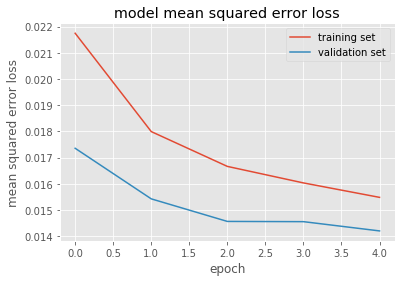

In [25]:
from keras.models import Model
import matplotlib.pyplot as plt

### mse  adam optimizer
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch = len(train_samples), 
                    validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=5)

model.save('model.h5')
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()